In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *

Using Theano backend.


In [2]:
import os

## Train linear model on predictions

- Use a Dense() layer to convert the 1,000 predictions given by our model into a probability of dog vs cat
- Train a linear model to take the 1,000 predictions as input, and return dog or cat as output, learning from the Kaggle data. 

### Training a model 

#### Config steps
- Copy a small amount of our data into a 'sample' directory, with the exact same structure as our 'train' directory
- Should do all of initial testing using a dataset small enough that we don't have to wait.

In [13]:
path = "data/redux/sample/"
#path = "data/redux/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

Trial and error to find the max batch size
- The max size doesn't give an 'out of memory' error.

In [14]:
#batch_size = 100
batch_size = 4

Start with VGG16 model because we'll use its predictions and features

In [3]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

#### Our overall approach:
1. Get the true labels for every image: isCat or isDog.
2. Get the 1,000 ImageNet category predictions for every image.
3. Feed these predictions as input to a linear model.

Grab training and validation batches:

In [15]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 8 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


To avoid loading the images every time we want to use them, we should save the processed arrays.
- The fastest way to save and load numpy arrays, use bcolz. This also compresses the arrays, so we save disk space. 
- The provided functions (save_array, load_array) are defined in utils.py

'get_data' function joins the arrays from all the batches.
Use this to grab the training and validation data:

In [16]:
val_data = get_data(path+'valid')

Found 8 images belonging to 2 classes.


In [17]:
trn_data = get_data(path+'train')

Found 16 images belonging to 2 classes.


In [18]:
trn_data.shape

(16, 3, 224, 224)

#### (1) Get true labels for every image
Keras returns classes as a single column, so we convert them to one hot encoding - using onehot function:

In [19]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [24]:
trn_labels.shape

(16, 2)

In [25]:
trn_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [26]:
trn_labels[:4]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

For each image, features for our linear model include
- the label
- 1,000 imagenet probabilties from VGG16

#### (2) Get the 1,000 ImageNet category predictions for every image.

In [27]:
#Generate predictions for the input samples.
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [28]:
trn_features.shape

(16, 1000)

In [29]:
save_array(model_path + 'train_lastlater_features.bc', trn_features)
save_array(model_path + 'valid_lastlater_features.bc', val_features)

#### (3) Feed these predictions as input to a linear model.
Define our linear model:

In [30]:
# 1000 inputs (the saved features), and 2 outputs (for dog & cat)
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

Fit the model:

In [31]:
#batch_size=64
batch_size=4

In [32]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 16 samples, validate on 8 samples
Epoch 1/3
16/16 [==============================] - 0s - loss: 0.5888 - acc: 0.6250 - val_loss: 0.4288 - val_acc: 0.8750
Epoch 2/3
16/16 [==============================] - 0s - loss: 0.3033 - acc: 1.0000 - val_loss: 0.3214 - val_acc: 0.8750
Epoch 3/3
16/16 [==============================] - 0s - loss: 0.2207 - acc: 1.0000 - val_loss: 0.2494 - val_acc: 0.8750


In [33]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2002
____________________________________________________________________________________________________


# Modifying the model

## Retrain last layer (linear model)

The VGG16 network's last layer is Dense (i.e. a linear model).
- It seems a little odd that we are adding an additional linear model on top of it.

The last layer had a softmax activation.
- which is an odd choice for an intermediate layer because we're going to add an extra layer on top of it.

What if we removed the last layer and replaced it with one trained for classifying cats and dogs?

Steps:
- Remove the last layer.
- Tell Keras to fix the weights in all the other layers (since we aren't looking to learn new parameters for those other layers).
- Add a new layer trained for classifying cats and dogs

In [4]:
#look at the layers of our VGG model
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [5]:
#Remove the last layer
model.pop()
#Tell Keras to fix the weights in all the other layers 
for layer in model.layers: layer.trainable = False

In [ ]:
model.add(Dense(2, activation='softmax'))

**Careful!** Be careful not to rerun any code in the previous sections, without first recreating the model from scratch!

Add our new final layer:

In [8]:
#View source code for finetune function
??vgg.finetune

In [9]:
#Remove the last layer & add a new layer are done in ft function
??vgg.ft

Compile our updated model and set up our batches to use the preprocessed images 
- Note: we will shuffle the training batches, to add more randomness when using multiple epochs

In [20]:
gen = image.ImageDataGenerator()
#Takes numpy data & label arrays, and generates batches of augmented/normalized data. 
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

Define a simple function for fitting models:

In [21]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch,
                       validation_data=val_batches, nb_val_samples=val_batches.N)

Use it to train the last layer of our model.

- It runs quite slowly, since it has to calculate all the previous layers in order to know what input to pass to the new final layer.
- We could pre-calculate the output of the penultimate layer.
- But since we're only likely to want one ore two iterations, it's easier to follow this alternative approach.

In [22]:
opt = RMSprop(lr=0.1)
#Configure the model for training.
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
16/16 [==============================] - 254s - loss: 1.2539 - acc: 0.8125 - val_loss: 4.0295 - val_acc: 0.7500
Epoch 2/2
16/16 [==============================] - 256s - loss: 7.2903 - acc: 0.4375 - val_loss: 4.0295 - val_acc: 0.7500


Save weights of all your models, so you can re-use them later. 

Be sure to note the git log number of your model when keeping a research journal of your results.

In [24]:
model.save_weights(model_path+'finetune1.h5')

In [25]:
model.load_weights(model_path+'finetune1.h5')

In [26]:
#Return the loss value & metrics values for the model in test mode.
model.evaluate(val_data, val_labels)

8/8 [==============================] - 85s


[4.0295238494873047, 0.75]

Look at the earlier prediction examples visualizations by redefining probs and preds, and re-using our earlier code:

In [27]:
#Generate class predictions for the input samples, batch by batch.
preds = model.predict_classes(val_data, batch_size=batch_size)
#Generate class probability predictions for the input samples, batch by batch.
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

8/8 [==============================] - 85s     


array([  1.0000e+00,   1.0000e+00,   1.0000e+00,   1.0000e+00,   9.0465e-38,   1.0000e+00,
         0.0000e+00,   0.0000e+00], dtype=float32)

In [28]:
cm = confusion_matrix(val_classes, preds)

[[4 1]
 [1 2]]


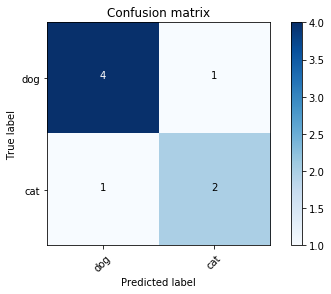

In [29]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

In [30]:
??model.predict_classes

In [31]:
??model.predict_proba